In [ ]:
!pip install pandas 
!pip install re
!pip install bs4
!pip install requests
!pip install spacy
!pip install networkx==2.6.3

In [ ]:
#import re
import pandas as pd
#import bs4
#import requests
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#for WikiDataset
candidate_sentences = pd.read_csv("/gdrive/MyDrive/wiki_sentences_v2.csv")
candidate_sentences.shape


(4318, 1)

In [ ]:
#for SocialQA Dataset
candidate_sentences = pd.read_json("/gdrive/MyDrive/dev.jsonl",lines=True)

candidate_sentences= candidate_sentences.rename(columns={"context": 'sentence'})
print(candidate_sentences.shape)
#questions = data['context']

(1954, 5)


In [ ]:
#candidate_sentences = pd.read_csv("/content/drive/MyDrive/wiki_sentences_v2.csv")
#candidate_sentences.shape


In [ ]:
candidate_sentences['sentence'].sample(5)

233     the 1970s was an era dominated by american hor...
4012    new yorker critic pauline kael echoed his crit...
1946    neil nitin mukesh and john abraham make extend...
2083    for the 2010, 2011 and 2012 film years, it was...
3071                           i'm the king of the world!
Name: sentence, dtype: object

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)


the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... amod
standard ... compound
d823 ... pobj


In [ ]:
def getEntities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    
    if tok.dep_ != "punct": # punctaions
      
      if tok.dep_ == "compound": #compound word?
        prefix = tok.text
        
        if prv_tok_dep == "compound": # continous compound word
          prefix = prv_tok_text + " "+ tok.text
      
      
      if tok.dep_.endswith("mod") == True: #modifier word?
        modifier = tok.text
        
        if prv_tok_dep == "compound": # complex word?
          modifier = prv_tok_text + " "+ tok.text
      
     
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
     
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
# testing entity extraction
getEntities("firefighter in the building ")

['', 'building']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(getEntities(i))

100%|██████████| 4318/4318 [00:41<00:00, 103.21it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

In [ ]:
def getRelation(sent):

  doc = nlp(sent)

   
  matcher = Matcher(nlp.vocab)

  #pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
getRelation("John completed the task")

'completed'

In [ ]:
relations = [getRelation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:46<00:00, 93.27it/s] 


In [ ]:
pd.Series(relations).value_counts()[:50]


is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

In [ ]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

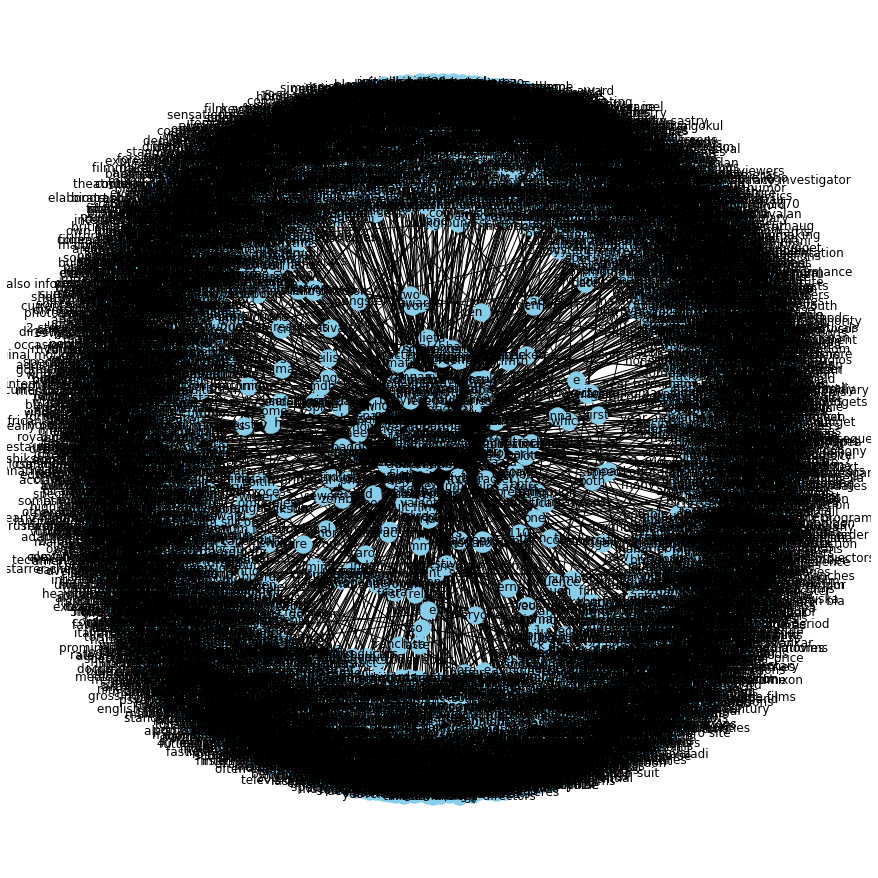

In [ ]:
import networkx as nx
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

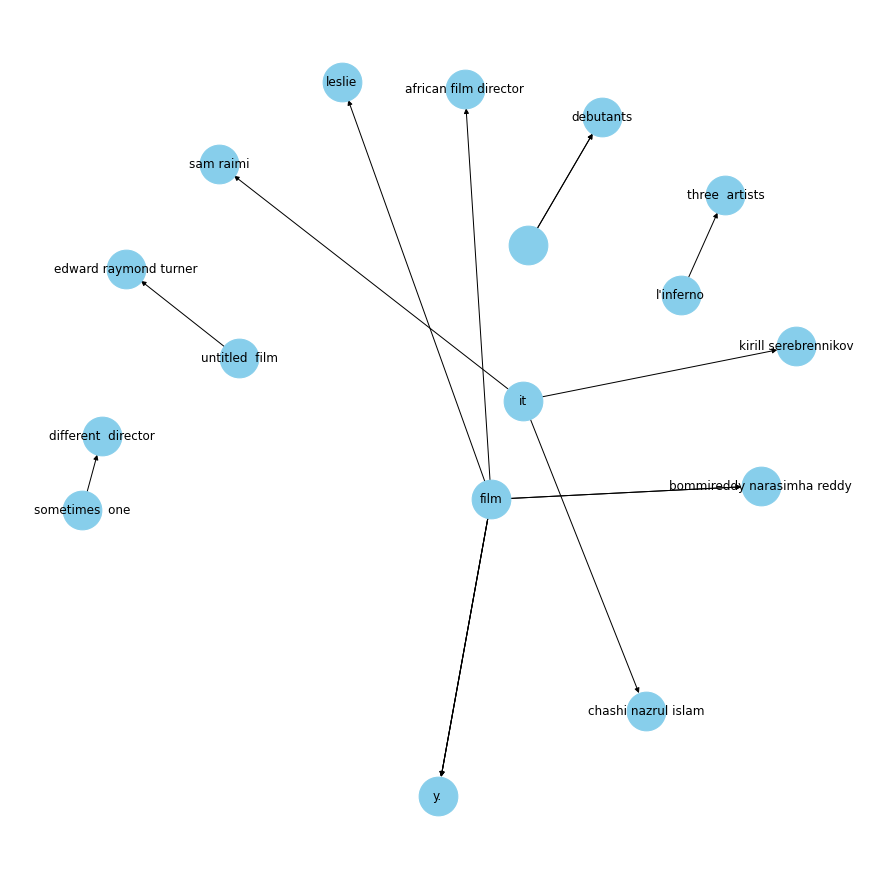

In [ ]:
# query for WikiDataset
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="directed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


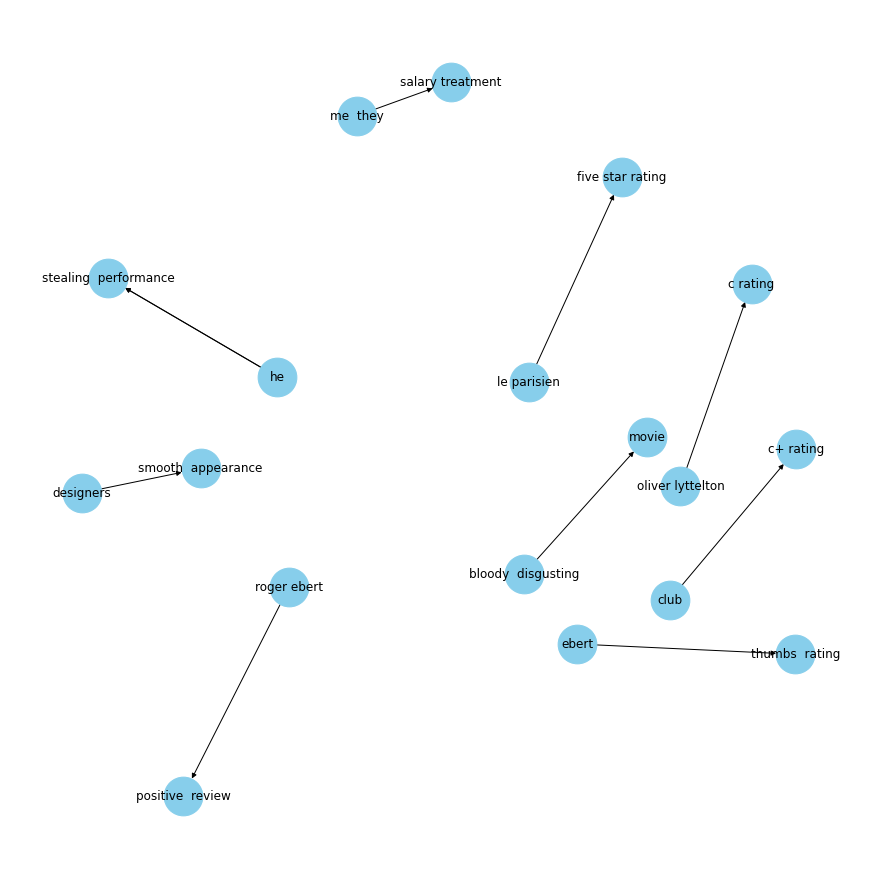

In [ ]:
# query for SocialQA
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="gave"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
